# Decision Tree (決定木) の実装

In [88]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import tree
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess

In [89]:
iris = load_iris()
X = iris.data
y = iris.target
X_df = pd.DataFrame(X,columns=iris.feature_names)
y_df = pd.DataFrame(y,columns=["Species"])
DF = pd.concat((X_df,y_df),axis=1)

#display(X_df)
#display(y_df)
display(DF.head())
display(DF.describe())

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Species
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [90]:
print("決定木をベースにした手法は線形な変換に依存しない")

"""
X_train, X_test, y_train, y_test = train_test_split(X,y)  #訓練データとテストデータの分割
scaler_std = StandardScaler()  #標準化コンストラクタ
scaler_std.fit(X_train)        #標準化の元

X_train_std = scaler_std.transform(X_train)  #訓練データの標準化
X_test_std  = scaler_std.transform(X_test)   #テストデータの標準化
"""

決定木をベースにした手法は線形な変換に依存しない


'\nX_train, X_test, y_train, y_test = train_test_split(X,y)  #訓練データとテストデータの分割\nscaler_std = StandardScaler()  #標準化コンストラクタ\nscaler_std.fit(X_train)        #標準化の元\n\nX_train_std = scaler_std.transform(X_train)  #訓練データの標準化\nX_test_std  = scaler_std.transform(X_test)   #テストデータの標準化\n'

## まずscikit-learnで実装

[Text(133.92000000000002, 199.32, 'X[2] <= 2.45\ngini = 0.666\nsamples = 112\nvalue = [36, 38, 38]'),
 Text(100.44000000000001, 163.07999999999998, 'gini = 0.0\nsamples = 36\nvalue = [36, 0, 0]'),
 Text(167.40000000000003, 163.07999999999998, 'X[2] <= 4.95\ngini = 0.5\nsamples = 76\nvalue = [0, 38, 38]'),
 Text(66.96000000000001, 126.83999999999999, 'X[3] <= 1.65\ngini = 0.1\nsamples = 38\nvalue = [0, 36, 2]'),
 Text(33.480000000000004, 90.6, 'gini = 0.0\nsamples = 35\nvalue = [0, 35, 0]'),
 Text(100.44000000000001, 90.6, 'X[1] <= 3.0\ngini = 0.444\nsamples = 3\nvalue = [0, 1, 2]'),
 Text(66.96000000000001, 54.359999999999985, 'gini = 0.0\nsamples = 2\nvalue = [0, 0, 2]'),
 Text(133.92000000000002, 54.359999999999985, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]'),
 Text(267.84000000000003, 126.83999999999999, 'X[3] <= 1.75\ngini = 0.1\nsamples = 38\nvalue = [0, 2, 36]'),
 Text(234.36, 90.6, 'X[3] <= 1.55\ngini = 0.444\nsamples = 6\nvalue = [0, 2, 4]'),
 Text(200.88000000000002, 54.3599

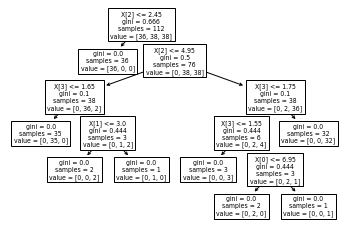

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X,y)  #訓練データとテストデータの分割

clf_tree = tree.DecisionTreeClassifier(max_depth=5)  #深さ指定
clf_tree.fit(X_train,y_train)  #学習・フィット

tree.plot_tree(clf_tree)

## フルスクラッチしよう

## CART法

Gini不純度を求める。

ジニ不純度を定義する関数は、



$$
I_G(t) = 1 - \sum^c_{i=1} p(i|t)^2  \\
p(i|t) = \frac{n_i}{n}
$$

エントロピーでは、
$$
I_H(t) = -\sum^c_{i=1} p(i|t) \log p(i|t)
$$

$
n : ノード内のサンプル数\\
n_i : iクラスのサンプル数
$

不純度が最も小さくなった時もっともよく分類できているといえます。

### ジニ不純度を求める関数

In [92]:
def _gini(y):
    
    """
    y : ノード内のデータ
    例：y = [0,0,1,1,0,1,2,1,0,0]
       IG = 1 - { (5/10)^2 + (4/10)^2 + (1/10)^2 }
          = 0.58
    """
    
    n_sample = len(y)
    y_set = list(set(y))
    n_class = len(y_set)
    
    IG = 1  #ジニ不純度初期化
    
    #ジニ不純度のサメンション部分を計算
    for c in range(n_class):
        #p部分計算
        ig = ( len(y[y==y_set[c]]) / n_sample )**2
        #ジニ不純度を更新
        IG -= ig
    
    return IG

ジニ不純度関数が正しく動いているかチェック

In [93]:
y = np.array([0,0,1,1,0,1,2,1,0,0])
_gini(y)

0.58

### ジニ不純度が最低になる場所の推定

目標は入れ子構造です。自分で実装するときは、まず深さ１の決定木から実装するといいと思います。

In [94]:
#決定木
class DecisionTree:
    def __init__(self,X=None,y=[0],max_depth=None):
        #条件を保存するためのノード
        self.X = X
        self.y = y
        self.max_depth = max_depth
        self.node_high = None
        self.node_low  = None
        self.tree = None
        self.label = np.argmax(np.bincount(y))
        
    #ジニ不純度を求める関数(_boundary_point関数内でループ)
    def _gini(self, X, y, axs, threshold):
        
        """
        y : ノード内のデータ
        例：y_yes  = [0,0,1,1,0,1,2,1,0,0]
           IG     = 1 - { (5/10)^2 + (4/10)^2 + (1/10)^2 }
                  = 0.58
        """
        
        flag  = X[:,axs] >= threshold
        _flag = np.logical_not(flag)
        #_flag = X[:,axs] < threshold
        
        y_ = [y[flag], y[_flag]]
        
        all_sample = len(y)
        
        y_set = list(set(y))
        n_class = len(y_set)
        
        IG = 0
        
        #ジニ不純度のサメンション部分を計算
        for y in y_:
            IG_cof = 1  #ジニ係数初期化
            n_sample = len(y)
            for c in y_set:
                if n_sample == 0:
                    break
                #p部分計算
                p = ( len(y[y==c]) / n_sample )**2
                #ジニ不純度を更新
                IG_cof -= p
            IG += IG_cof * ( len(y) / all_sample )
        
        return IG
    
    
    #入れ子構造になっている
    def _serch_split(self, X, y, depth=1):
        
        """
        X      : 全てのデータ
        y      : Xのラベル
        depth  : 今の深さ
        """
        self.depth = depth
        n_axs = X.shape[1]
        
        gini_flag1 = 1
        gini_flag2 = 1
        
        split_value1 = 0
        split_value2 = 0
        
        #ジニ不純度が最小になる軸とその時の値を二つ
        for axs in range(n_axs):
            X_set = list(set(X[:, axs]))          #同じ値は必要ないので除去
            for i,x in enumerate(X_set):
                gini = self._gini(X,y,axs,x)      #ジニ不純度を計算
                #中間値をとるための処理
                if gini_flag2 > gini:             #二番目に小さいジニよりも小さいか
                    if gini_flag1 > gini:         #一番小さいジニよりさらに小さいとき
                        gini_flag1 = gini         #一番小さいジニ不純度更新
                        split_value1 = x          #一番小さいジニをとる値を保存
                        best_axs = axs            #一番小さいジニをとる軸を保存
                        c = y[np.where(X==x)[0]]         #一番小さいジニをとるクラスタの保存
                    elif best_axs == axs:         #軸が同じか
                        if c != y[np.where(X==x)[0]]:#同じクラスタの次に小さいやつをとっても意味ないから
                            gini_flag2 = gini     #同じなら二番目に小さいジニを保存
                            split_value2 = x      #二番目に小さいジニをとる値を保存して

        #argmin()でもいける？
        
        #境界値算出(算術平均)
        split_point = ( split_value1 + split_value2 ) / 2
        """debug
        print("axis =",best_axs)
        print("depth =", depth)
        print("boundary_line =",split_point)
        print("GINI =",gini_flag1)
        """
        
        
        return gini_flag1,split_point,best_axs
        
    def _split(self,depth,last=False):
        
        self.gini_min, self.boundary_line, self.best_axs = self._serch_split(self.X, self.y, depth)
        
        #左右のノード抽出
        flag   = X[:,self.best_axs]>=self.boundary_line
        _flag  = np.logical_not(flag)
        X_high = X[flag]
        X_low  = X[_flag]
        y_high = y[flag]
        y_low  = y[_flag]
        
        self.node_high = DecisionTree(X_high, y_high, self.max_depth)
        self.node_low  = DecisionTree(X_low, y_low, self.max_depth)
        
        #ジニ不純度が０でなく深さが指定以下の時まだ続ける
        if self._gini == 0 or self.max_depth == depth:
            #もう一回下の木に行く
            if last:
                pass
            else:
                last = True
                self.node_high._split(depth,last)
                self.node_low._split(depth,last)
                
        else:
            #深さの更新
            depth += 1
            self.node_high._split(depth)
            self.node_low._split(depth)
    
    def pred(self, X_test,last=False):
        if self.gini_min == 0 or self.max_depth == self.depth:
            if last:
                return self.label
            else:
                last = True
                if X_test[self.best_axs] >= self.boundary_line:
                    return self.node_high.pred(X_test,last)
                else:
                    return self.node_low.pred(X_test,last)
            
            
            #if X_test[self.best_axs] >= self.boundary_line:
            #    return self.node_high.pred(X_test).label
            #else:
            #    return self.node_low.pred(X_test).label
            
        else:
            if X_test[self.best_axs] >= self.boundary_line:
                return self.node_high.pred(X_test)
            else:
                return self.node_low.pred(X_test)

    def fit(self, X, y, max_depth=3):
        self.tree = DecisionTree(X, y, max_depth)
        self.tree._split(1)
        
    def predict(self,X_test):
        pred = np.zeros(X_test.shape[0],"uint")
        for i,t in enumerate(X_test):
            pred[i] = (self.tree.pred(t))
        
        return np.array(pred)


## テストデータで実験

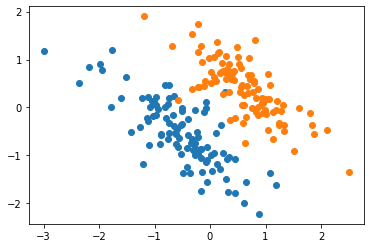

In [95]:
data = 100
mu1 = [-0.5,-0.5]
sigma = [[0.49,-0.40],
         [-0.40,0.49]]
mu2 = [0.5,0.5]

class1 = np.random.multivariate_normal(mu1,sigma,data)
class2 = np.random.multivariate_normal(mu2,sigma,data)
y = np.concatenate((np.zeros(data),np.ones(data)),axis=0).astype(int)
X = np.concatenate((class1,class2),axis=0)

plt.scatter(class1[:,0],class1[:,1])
plt.scatter(class2[:,0],class2[:,1])

In [96]:
clf = DecisionTree()
clf.fit(X,y,max_depth = 14)

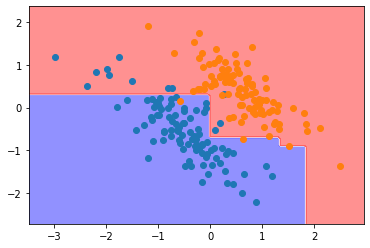

In [97]:
mesh_x = np.arange(np.min(X[:,0])-0.5,np.max(X[:,0])+0.5,0.05)
mesh_y = np.arange(np.min(X[:,1])-0.5,np.max(X[:,1])+0.5,0.05)
xv, yv = np.meshgrid(mesh_x, mesh_y)

mesh = []
for xx, yy in zip(xv, yv):
    for x, y in zip(xx, yy):
        mesh.append([x,y])
mesh = np.array(mesh)

plt.contourf(mesh_x,mesh_y,clf.predict(mesh).reshape(xv.shape),cmap="bwr",alpha=0.5)
plt.scatter(class1[:,0],class1[:,1])
plt.scatter(class2[:,0],class2[:,1])
plt.show()